you have to add image zip files shortcut link to your drive and give the address to the Dataset class

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries and Functions

In [4]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset , DataLoader


os.system('pip install facenet-pytorch')
from facenet_pytorch import MTCNN



## Dataset Class Definition

In [5]:
import os
import cv2
from torch.utils.data import Dataset

class MSCTDDataset(Dataset):
    def __init__(self, img_dir, mode , transform=None, target_transform=None,resize = None):
        # downloading text files from github
        print('\nLoading Text Files')
        os.system('git clone https://github.com/XL2248/MSCTD.git')
        #unziping images
        if mode == 'train':
          print('Loading Train Images')
          os.system('unzip -n '+ os.path.join(img_dir,'train_ende.zip'))
          os.system('mv train_ende train')
          print('Train Images Count:', len(os.listdir('train')))
          os.system('cp -r MSCTD/MSCTD_data/ende/english_train.txt -t train')
          os.system('cp -r MSCTD/MSCTD_data/ende/image_index_train.txt -t train')
          os.system('cp -r MSCTD/MSCTD_data/ende/sentiment_train.txt -t train')
        

        if mode == 'dev':
          print('Loading Validation Images')
          os.system('unzip -n '+ os.path.join(img_dir,'dev.zip'))
          print('Dev Images Count:', len(os.listdir('dev')))
          os.system('cp -r MSCTD/MSCTD_data/ende/english_dev.txt -t dev')
          os.system('cp -r MSCTD/MSCTD_data/ende/image_index_dev.txt -t dev')
          os.system('cp -r MSCTD/MSCTD_data/ende/sentiment_dev.txt -t dev')
        

        if mode == 'test':
          print('Loading Test Images')
          os.system('unzip -n '+ os.path.join(img_dir,'test.zip'))
          print('Test Images Count:', len(os.listdir('test')))
          os.system('cp -r MSCTD/MSCTD_data/ende/english_test.txt -t test')
          os.system('cp -r MSCTD/MSCTD_data/ende/image_index_test.txt -t test')
          os.system('cp -r MSCTD/MSCTD_data/ende/sentiment_test.txt -t test')

        os.system('rm -r MSCTD')
        # processing text files and saving them as attribute of dataset
        file1 = open(mode + '/sentiment_' + mode + '.txt', 'r')
        Lines = file1.readlines()
        file1.close()
        label = []
        for line in Lines:
            line = line.strip()
            label.append(int(line))         
        self.sentiment = np.array(label)

        file1 = open(mode + '/english_' + mode + '.txt', 'r')
        Lines = file1.readlines()
        file1.close()
        text = []
        for line in Lines:
            line = line.strip()
            text.append(line)  
        self.text = text

        image_index = []
        file1 = open(mode + '/image_index_' + mode + '.txt', 'r')
        Lines = file1.readlines()
        file1.close()
        text = []
        for line in Lines:
            line = line.strip()
            image_index.append(line) 
        self.image_index = image_index

        self.mode = mode
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resize = resize
        
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        img_path = os.path.join(self.mode, f'{idx}.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        sentiment = self.sentiment[idx]
        text = self.text[idx]
        if self.resize:
              image = cv2.resize(image, self.resize) 
        else :
              image = cv2.resize(image, (1280,633)) 

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            sentiment = self.target_transform(sentiment)
        return {'text':text ,'image':image, 'sentiment':(sentiment)}

## Building Datasets and Dataloader

"img_dir" is the address of the folder that inculde zip files

In [6]:
train_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'train', transform = None, resize = (640,316))
val_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'dev', transform = None, resize = (640,316))
test_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'test', transform = None, resize = (640,316))

train_dataloader =  DataLoader(train_data, batch_size=100)
val_dataloader =  DataLoader(val_data, batch_size=100)
test_dataloader =  DataLoader(test_data, batch_size=100)



Loading Text Files
Loading Train Images
Train Images Count: 20240

Loading Text Files
Loading Validation Images
Dev Images Count: 5063

Loading Text Files
Loading Test Images
Test Images Count: 5067


## Part 2

### A (Sentiment Distribution)

In [7]:
def make_histogram(feature , dataset_type):
    bins = np.unique(feature)
  
    plt.figure(figsize=(5,5))
    plt.hist(feature,bins=bins.shape[0],alpha =0.4 ,histtype='bar', ec='black')
    plt.xticks(bins)
    plt.title(f'Sentiment histogram for {dataset_type} data')
    plt.show()

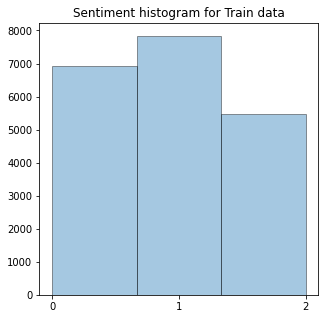

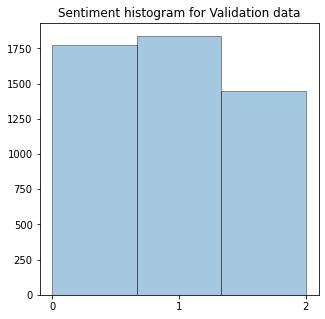

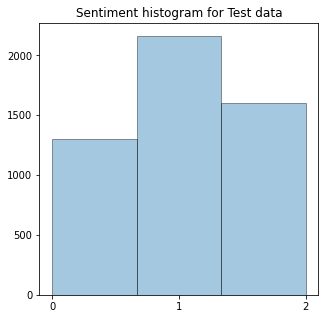

In [8]:
make_histogram (train_data.sentiment, 'Train')
make_histogram (val_data.sentiment, 'Validation')
make_histogram (test_data.sentiment, 'Test')

as you can see the distribution of 3 dataset is almost the same, expect that test  set has less data with sentiment 0.

### B (Word Count)

In [9]:
def feature_analyze(feature,dataset_type,feature_name):
    number_of_words=[]
    for text in feature:
        number_of_words.append(len(text.split()))

    number_of_words = np.array(number_of_words)
    min_n = np.min(number_of_words)
    max_n = np.max(number_of_words)
    mean = np.mean(number_of_words)
    var = np.var(number_of_words)
    print(f'{feature_name} in {dataset_type} Set: Mean =', '{:.3f}'.format(mean),'and Variance =','{:.3f}'.format(var))

    n_bins = max_n - min_n +1
    bins = np.linspace(min_n , max_n , n_bins)
    plt.figure(figsize=(10,5))
    plt.hist(number_of_words,bins=n_bins-1,alpha =0.4 ,histtype='bar', ec='black')
    plt.xticks(bins)
    plt.title(f'{feature_name} Histogram for {dataset_type} Set')
    plt.show()
    return number_of_words


Number of Words per Sentences in Train Set: Mean = 6.464 and Variance = 9.247


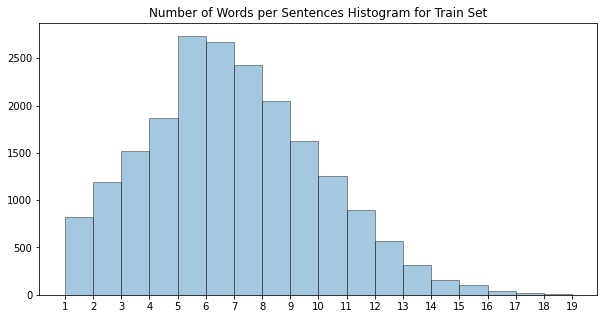

Number of Words per Sentences in Validation Set: Mean = 6.310 and Variance = 8.631


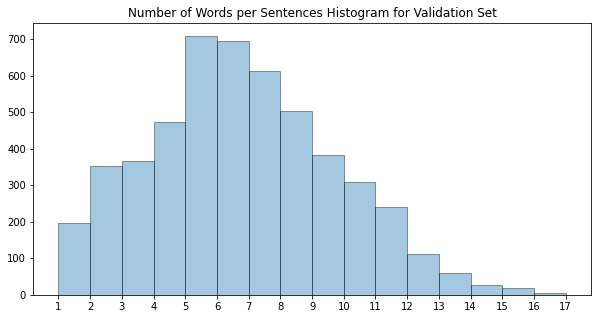

Number of Words per Sentences in Test Set: Mean = 6.304 and Variance = 8.893


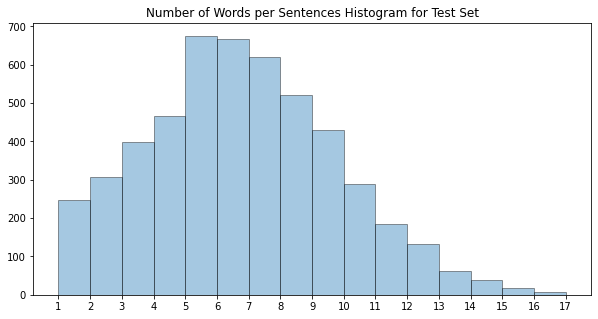

In [10]:
train_number_of_words = feature_analyze(train_data.text , 'Train', 'Number of Words per Sentences')
val_number_of_words = feature_analyze(val_data.text , 'Validation', 'Number of Words per Sentences')
test_number_of_words = feature_analyze(test_data.text , 'Test', 'Number of Words per Sentences')

the distribution of 3 dataset is almost the same for word per sentences and its gussian as you could guess.

### C (Scene Count)

Number of Scenes per Conversation in Train Set: Mean = 9.797 and Variance = 17.696


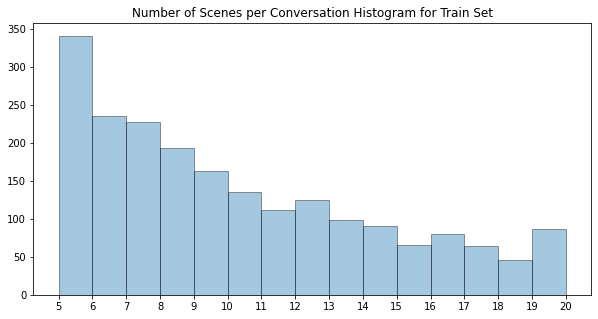

Number of Scenes per Conversation in Validation Set: Mean = 10.046 and Variance = 19.254


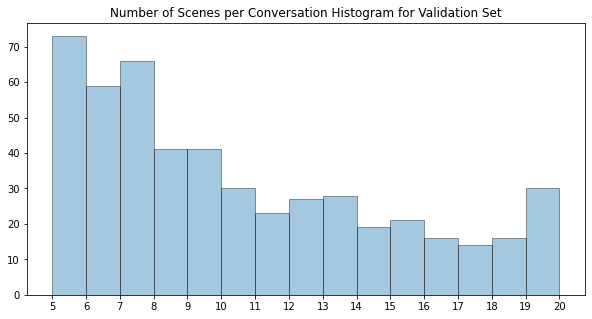

Number of Scenes per Conversation in Test Set: Mean = 9.955 and Variance = 17.752


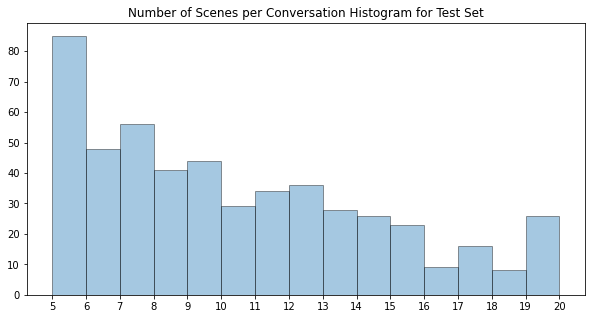

In [11]:
train_number_of_scenes = feature_analyze(train_data.image_index , 'Train','Number of Scenes per Conversation')
val_number_of_scenes = feature_analyze(val_data.image_index , 'Validation','Number of Scenes per Conversation')
test_number_of_scenes = feature_analyze(test_data.image_index , 'Test','Number of Scenes per Conversation')

it shows the that most of the conversations include less than 5 scenes and it has minimum of 5 dialogue (which has the most number of conversation)

### D (Face Count)

In [12]:
def face_detector(dataloader,dataset_type):
    detector = MTCNN()
    number_of_face = []

    for batch in dataloader:
        images = batch['image']
        for image in images:
            boxes, probs = detector.detect(image,landmarks=False )
            try:
              number_of_face.append(len(boxes))
            except:
              number_of_face.append(0)
    number_of_face = np.array(number_of_face)

    min_n = np.min(number_of_face)
    max_n = np.max(number_of_face)
    mean = np.mean(number_of_face)
    var  = np.mean(number_of_face)
    print(f'Number of Faces in {dataset_type} Set: Mean =', '{:.3f}'.format(mean),'and Variance =','{:.3f}'.format(var))

    n_bins = max_n - min_n + 1
    bins = np.linspace(min_n, max_n, n_bins)
    plt.figure(figsize=(20,5))
    plt.hist(number_of_face,bins=n_bins-1,alpha =0.4 ,histtype='bar', ec='black')
    plt.xticks(bins)
    plt.title(f'Number of faces histogram for {dataset_type} data')
    plt.show()
    return number_of_face

Number of Faces in Trian Set: Mean = 1.383 and Variance = 1.383


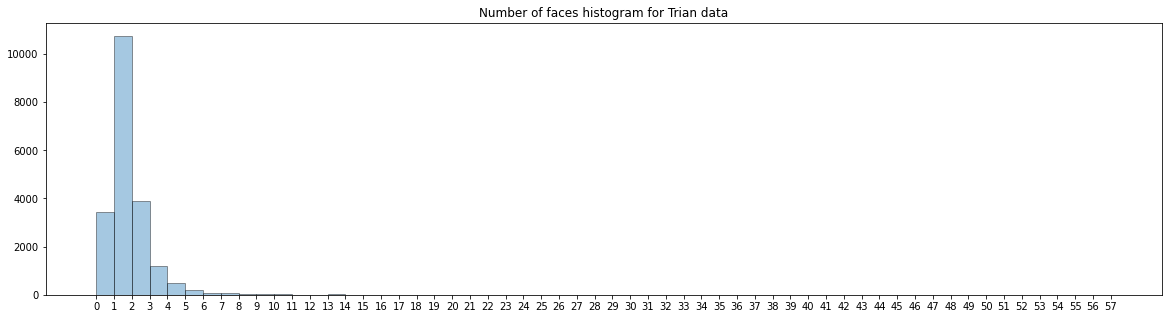

Number of Faces in Validation Set: Mean = 1.284 and Variance = 1.284


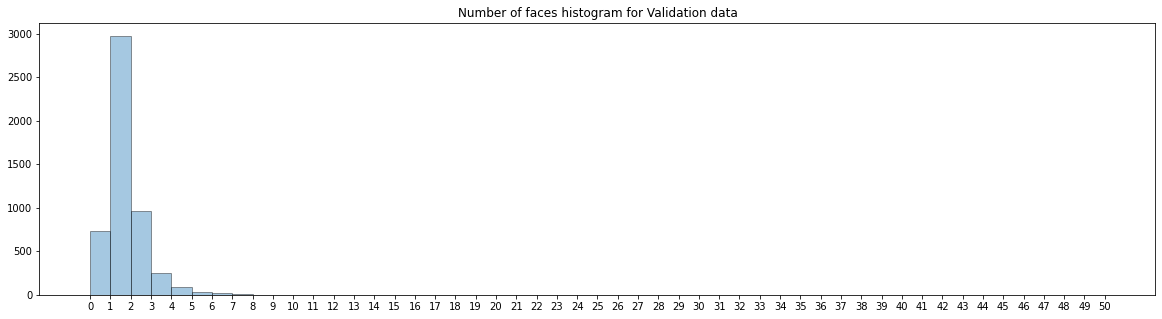

Number of Faces in Test Set: Mean = 1.387 and Variance = 1.387


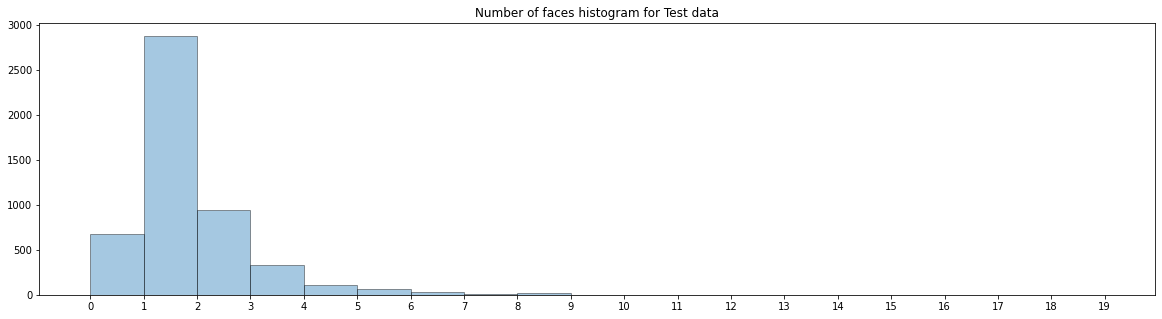

In [15]:
train_number_of_face = face_detector(train_dataloader, 'Trian')
val_number_of_face = face_detector(val_dataloader, 'Validation')
test_number_of_face = face_detector(test_dataloader, 'Test')

it is good that most of the photos include only 1 face cuase other was the label wouldn't be accurate enough. and each dataset has its own outlier data that has so many faces and better be removed during learning. most of the images have up to 3 faces and we can try droping the rest of them for better result

Maximum Number of Face in a Single Image in Train Set: 57


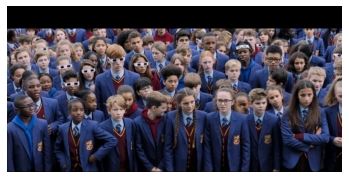

Maximum Number of Face in a Single Image in Validation Set: 50


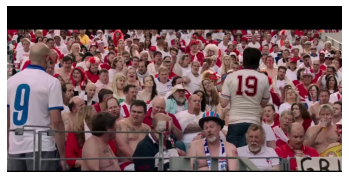

Maximum Number of Face in a Single Image Test Set: 19


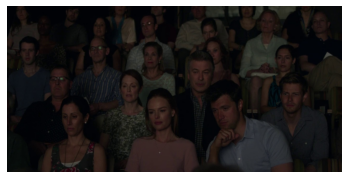

In [21]:
print('Maximum Number of Face in a Single Image in Train Set:',train_number_of_face[np.argmax(train_number_of_face)])
plt.imshow(train_data[np.argmax(train_number_of_face)]['image'])
plt.axis('off')
plt.show()

print('Maximum Number of Face in a Single Image in Validation Set:',val_number_of_face[np.argmax(val_number_of_face)])
plt.imshow(val_data[np.argmax(val_number_of_face)]['image'])
plt.axis('off')
plt.show()

print('Maximum Number of Face in a Single Image Test Set:',test_number_of_face[np.argmax(test_number_of_face)])
plt.imshow(test_data[np.argmax(test_number_of_face)]['image'])
plt.axis('off')
plt.show()

### E (Correlation)

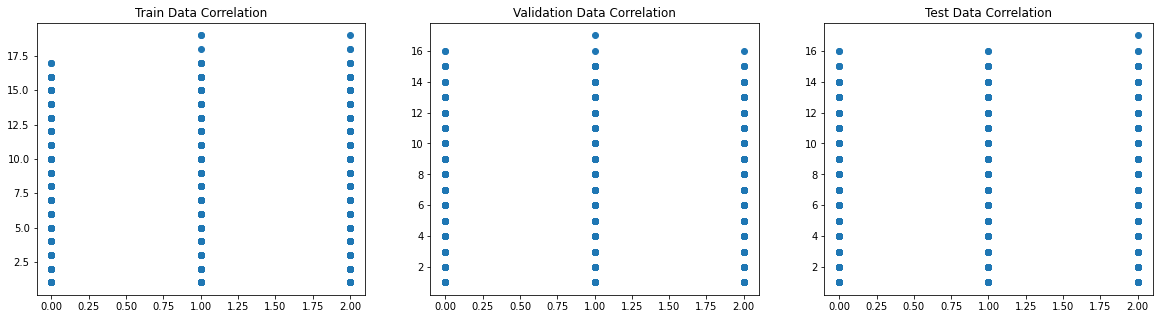

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(train_data.sentiment,train_number_of_words)
plt.title('Train Data Correlation')

plt.subplot(1,3,2)
plt.scatter(val_data.sentiment,val_number_of_words)
plt.title('Validation Data Correlation')

plt.subplot(1,3,3)
plt.scatter(test_data.sentiment,test_number_of_words)
plt.title('Test Data Correlation')
plt.show()

### F (Pattern)

this function has 3 output. first the list that each object is all of sentiments in a conversation. secend is a list each object is the pattern of the conversation.third the number that classify the pattern.
we think of each pattern as a number in base of 4 (we add 1 to each sentiment), then calculate that number in decimal.

In [17]:
def hist_time_serie(image_index , sentiments):
    time_serie = []
    hist_serie = []
    class_serie = np.zeros((len(image_index),1))
    for ii,line in enumerate(image_index):
        #print('scene:',line)
        line = line.replace('[',' ').replace(']' ,' ' ).replace(',',' ').split()
        sentiment = []
      
        for index in line:
            sentiment.append(sentiments[int(index)])
        
        time_serie.append(sentiment)
        hist = []
        
        #print('serie:',sentiment)
        before = int(sentiment[0])
        class_serie[ii] =  (before+1)
        hist.append(before)
        for i in sentiment[1:]:
          if int(i) == before:
              s=5
          else:
              hist.append(i)
              before = int(i)
              class_serie[ii] = 4*class_serie[ii] + (before+1)
        hist_serie.append(hist)
        
        #print('hist:',hist , class_serie[ii],i)
  
    return time_serie , hist_serie , class_serie


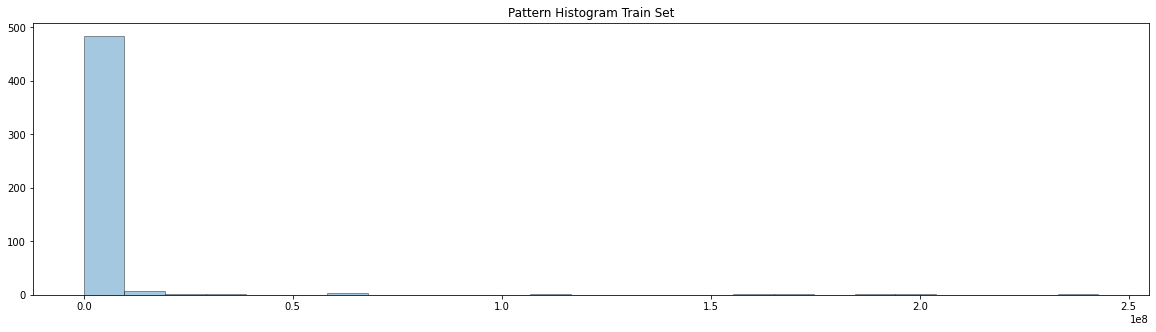

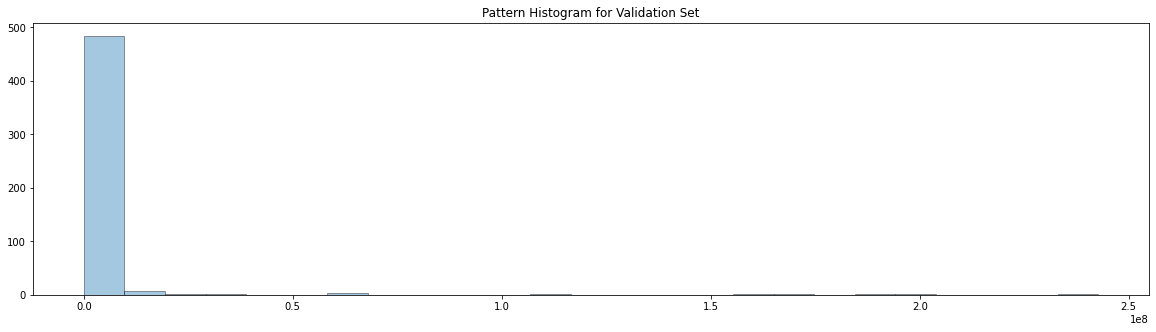

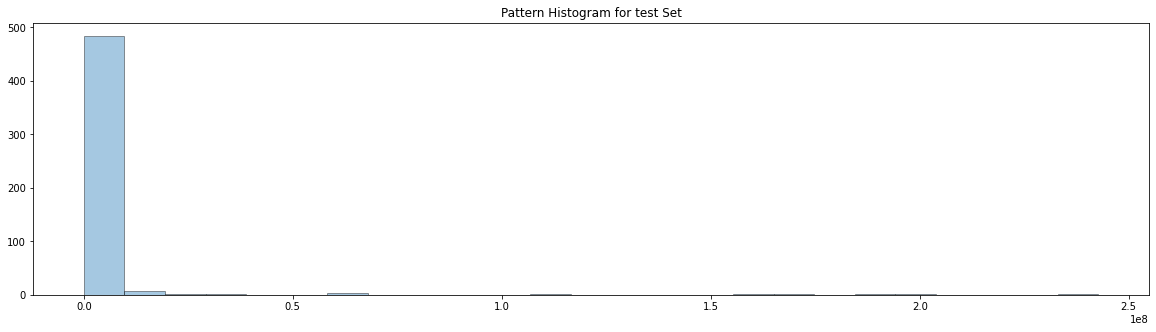

In [18]:
time_serie_train, hist_serie_train, class_serie_train = hist_time_serie(val_data.image_index, val_data.sentiment)
plt.figure(figsize=(20,5))
plt.hist(class_serie_train,bins=25,alpha =0.4 ,histtype='bar', ec='black')
plt.title('Pattern Histogram Train Set')
plt.show()


time_serie_val , hist_serie_val,class_serie_val = hist_time_serie(val_data.image_index, val_data.sentiment)
plt.figure(figsize=(20,5))
plt.hist(class_serie_val,bins=25,alpha =0.4 ,histtype='bar', ec='black')
plt.title('Pattern Histogram for Validation Set')
plt.show()


time_serie_test , hist_serie_test,class_serie_test = hist_time_serie(val_data.image_index, val_data.sentiment)
plt.figure(figsize=(20,5))
plt.hist(class_serie_test,bins=25,alpha =0.4 ,histtype='bar', ec='black')
plt.title('Pattern Histogram for test Set')
plt.show()

as you see this histogram dosent give us that much information so we plot the histogram for patterns with small class number.

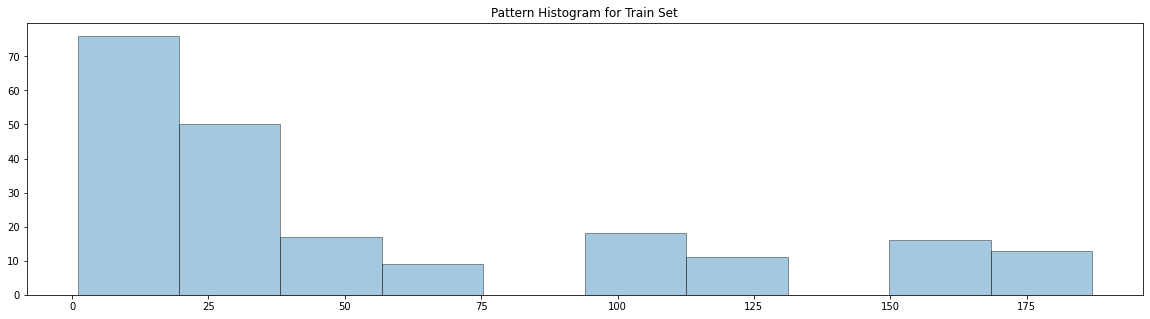

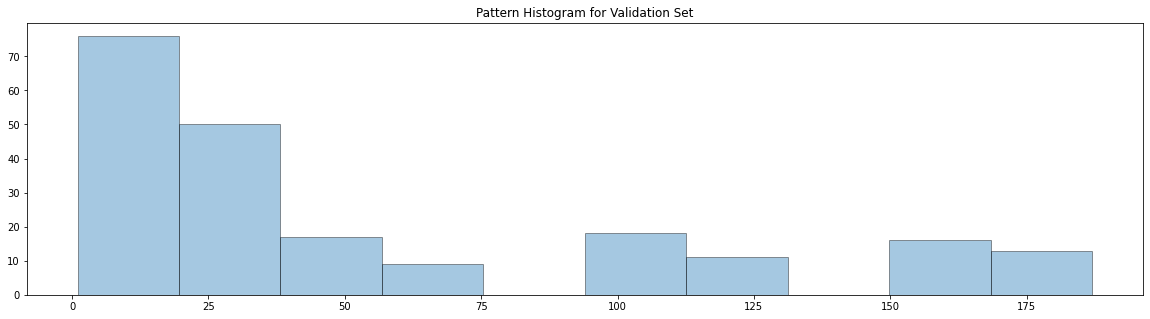

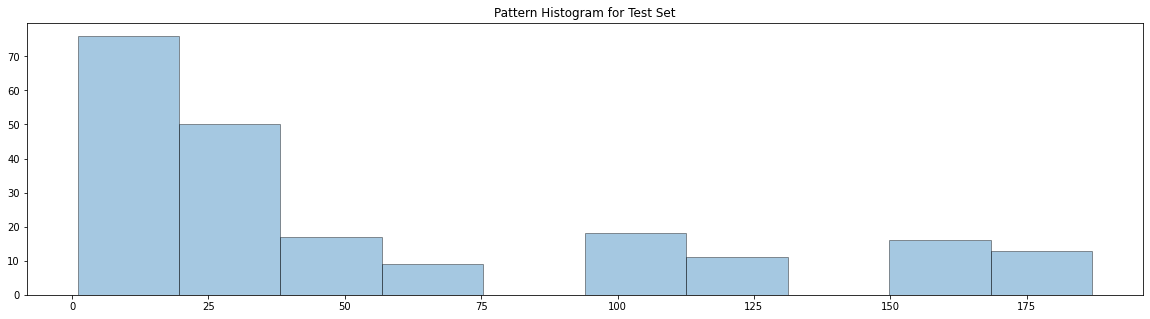

In [20]:
import pandas as pd
df = pd.DataFrame(class_serie_train,columns=['a'])
df = df[df.a<200]
a = np.array(df)
plt.figure(figsize=(20,5))
plt.hist(a,bins=10,alpha =0.4 ,histtype='bar', ec='black')
plt.title('Pattern Histogram for Train Set')
plt.show()


df = pd.DataFrame(class_serie_val,columns=['a'])
df = df[df.a<200]
a = np.array(df)
plt.figure(figsize=(20,5))
plt.hist(a,bins=10,alpha =0.4 ,histtype='bar', ec='black')
plt.title('Pattern Histogram for Validation Set')
plt.show()


df = pd.DataFrame(class_serie_test,columns=['a'])
df = df[df.a<200]
a = np.array(df)
plt.figure(figsize=(20,5))
plt.hist(a,bins=10,alpha =0.4 ,histtype='bar', ec='black')
plt.title('Pattern Histogram for Test Set')
plt.show()

it shows that most of the conversation has small class-number, which means the patters have low number of digits

In [19]:
mean = int(np.mean(train_number_of_scenes))
total = 0
for i in range (mean):
    total = total + 3**i
print('Total Number of Histogream Classes is:',total)
unique = np.unique(class_serie_train)
print('Observed Histogram Classes is:',unique.shape[0])


mean = int(np.mean(val_number_of_scenes))
total = 0
for i in range (mean):
    total = total + 3**i
print('Total Number of Histogream Classes is:',total)
unique = np.unique(class_serie_val)
print('Observed Histogram Classes is:',unique.shape[0])


mean = int(np.mean(test_number_of_scenes))
total = 0
for i in range (mean):
    total = total + 3**i
print('Total Number of Histogream Classes is:',total)
unique = np.unique(class_serie_test)
print('Observed Histogram Classes is:',unique.shape[0])

Total Number of Histogream Classes is: 9841
Observed Histogram Classes is: 250
Total Number of Histogream Classes is: 29524
Observed Histogram Classes is: 250
Total Number of Histogream Classes is: 9841
Observed Histogram Classes is: 250


it means that all the patterns are not possible in real conversation and they dont happen. 